### Habitat Suitability

&nbsp;

Habitat suitability model predicts the abundance of a certain species in a particular area. Based on the availability of these environmental elements throughout a landscape, the model determines which environmental factors a species prefers or avoids. The result would be an index of habitat suitability based on these factors. The model in this script is listed below.

$$Number of Animals Captured = \alpha + \beta_1 \times Vegetation Type + \beta_2 \times Prey Presence  + \beta_3 \times Altitude $$

where

$\alpha$,$\beta$ denotes the coefficients of the model

In [1]:
import sklearn.ensemble
import shapely.geometry
import cv2
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/maria')

### read data

In [2]:
df=pd.DataFrame(columns=['ID', 'SPECIES_CODE', 'SPECIES_NAME', 'CURRENT_SPECIES_NAME',
       'POPULATION', 'PREFERRED_COMMON_NAMES', 'PROJECT_CODE',
       'OBSERVATION_FOREIGN_ID', 'GDA94_ZONE_55_EASTINGNORTHING', 'LONGITUDE',
       'LATITUDE', 'EASTING', 'NORTHING', 'POSITION_ACCURACY', 'LOCATION_DESC',
       'OBSERVER_NAMES', 'OBSERVATION_DATE', 'DATE_ACCURACY',
       'OBSERVATION_TYPE', 'OBSERVATION_TYPE_QUALIFIER', 'OBSERVATION_STATE',
       'OBSERVATION_STATE_QUALIFIER', 'RECORD_STATUS', 'NOTES',
       'PRIMARY_IDENTIFIER',])

#species data come from https://www.naturalvaluesatlas.tas.gov.au/#NaturalValuesReportPage
for i in os.listdir():
    if '.csv' in i:
        data=pd.read_csv(i)
        df=df.append(data)

C:\Users\tm\AppData\Local\Temp\ipykernel_12140\4189780825.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data)
C:\Users\tm\AppData\Local\Temp\ipykernel_12140\4189780825.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data)
C:\Users\tm\AppData\Local\Temp\ipykernel_12140\4189780825.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data)
C:\Users\tm\AppData\Local\Temp\ipykernel_12140\4189780825.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(data)
C:\Users\tm\AppData\Local\Temp\ipykernel_12140\4189780825.py:14: FutureWarning: The frame.append method is deprecated and wi

### global variables

In [3]:
lonmin=147.992312;latmin=-42.755783;
lonmax=148.252213;latmax=-42.564998;
lat_centre =-42.653436; lon_centre = 148.095996;
gridlen=20

### island map

In [4]:
#create map
#alternative projection could be crs4236 wgs84
carte=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,
              urcrnrlon=lonmax,urcrnrlat=latmax,
              resolution='f', projection='tmerc', 
             lat_0=lat_centre,lon_0=lon_centre,)

carte.drawmapboundary(fill_color='w')
carte.fillcontinents(color='k',lake_color='w')
carte.drawcoastlines()
plt.savefig('./images/base.png',bbox_inches='tight',
                    pad_inches=-.05)
plt.clf()


#down scale image
baselayer=cv2.imread('./images/base.png',0)
baselayer=cv2.resize(baselayer,dsize=(gridlen,gridlen,),
                   interpolation=cv2.INTER_AREA)
        

<Figure size 640x480 with 0 Axes>

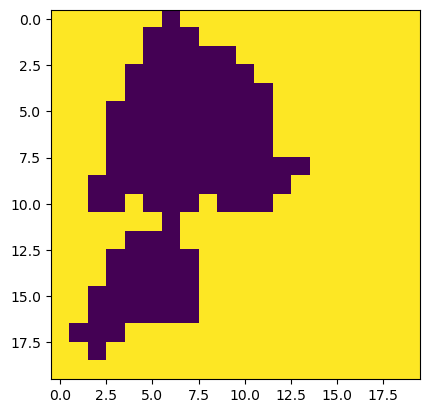

In [5]:
#manual dilution
baselayer[baselayer>=180]=255
baselayer[baselayer<180]=0
plt.imshow(baselayer)

### NVA devil

In [6]:
#get devil
subset=df[df['PREFERRED_COMMON_NAMES']=='tasmanian devil'].copy()

In [7]:
#locate where the devils are on a 20 by 20 raster
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
subset['lat num']=(subset['LATITUDE']-latmin)//latunit
subset['lon num']=(subset['LONGITUDE']-lonmin)//lonunit
subset['coordinates']=list(zip(subset['lat num'].astype(int),subset['lon num'].astype(int)))

In [8]:
#create matrix
devilcount=subset.groupby(['coordinates']).count()
devil=np.zeros((gridlen,gridlen))
for i in range(len(devilcount)):
    devil[devilcount.index[i]]=devilcount['ID'].iloc[i]

#flip matrix vertically
devil=np.flip(devil,0)

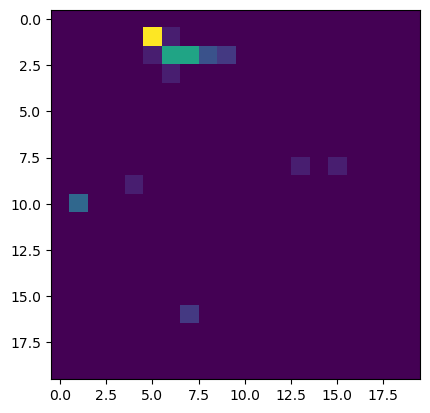

In [9]:
plt.imshow(devil)

### NVA birds

In [10]:
#get seabrids
food=df[df['PREFERRED_COMMON_NAMES'].isin(['little penguin', 'short-tailed shearwater'])]

In [11]:
#create map
carte=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,
              urcrnrlon=lonmax,urcrnrlat=latmax,
              resolution='f', projection='tmerc', 
             lat_0=lat_centre,lon_0=lon_centre,)
carte.drawmapboundary(fill_color='w')
x,y=carte(food['LONGITUDE'].tolist(),food['LATITUDE'].tolist())
plt.scatter(x,y,s=100,c='red')
plt.savefig('./images/bird.png',bbox_inches='tight',
                    pad_inches=-.05)
plt.clf()

#down scale image
bird=cv2.imread('./images/bird.png',0)
bird=cv2.resize(bird,dsize=(gridlen,gridlen),
                   interpolation=cv2.INTER_LANCZOS4)

<Figure size 640x480 with 0 Axes>

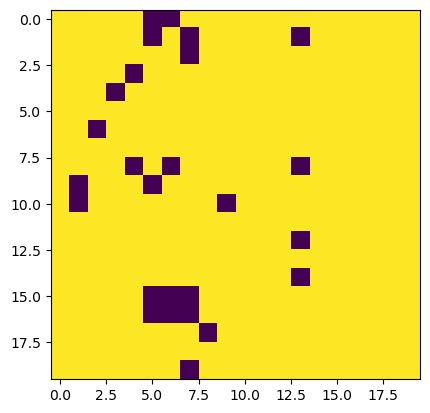

In [12]:
#viz
bird[bird<255]=0
plt.imshow(bird)

### vegetation

PROJ: proj_create_from_database: Cannot find proj.db


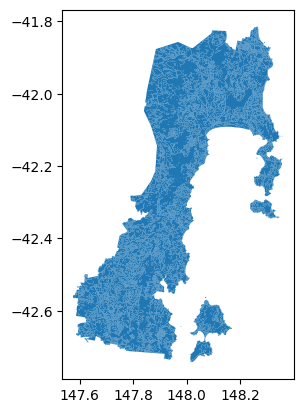

In [13]:
#convert stupid utm to lat lon
zips = gpd.read_file('./LIST_TASVEG_40_GLAMORGAN_SPRING_BAY/list_tasveg_40_glamorgan_spring_bay.shp')
zips = zips.to_crs('epsg:4326')
#+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs
zips.plot()
plt.show()
zips.to_file('./LIST_TASVEG_40_GLAMORGAN_SPRING_BAY/maria.shp', driver='ESRI Shapefile')

In [14]:
#crop to maria island
subset=zips.cx[lonmin:lonmax,
              latmin:latmax]

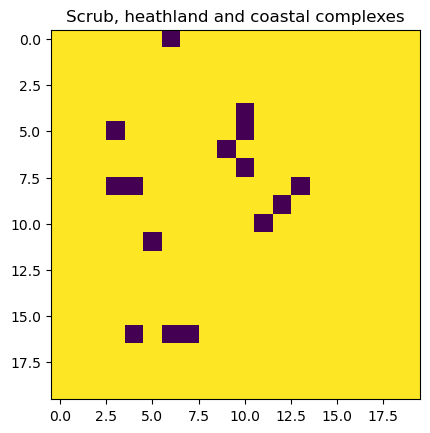

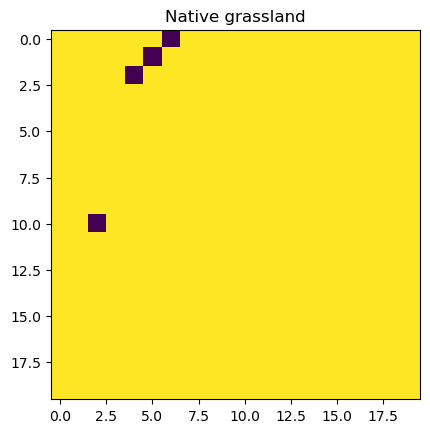

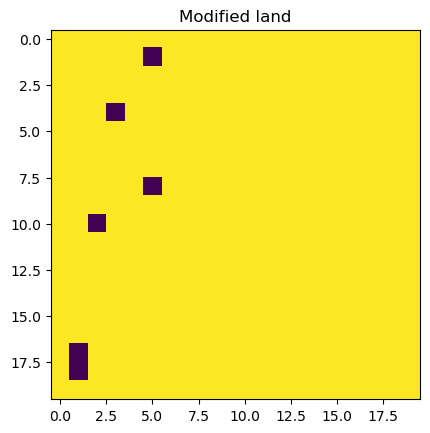

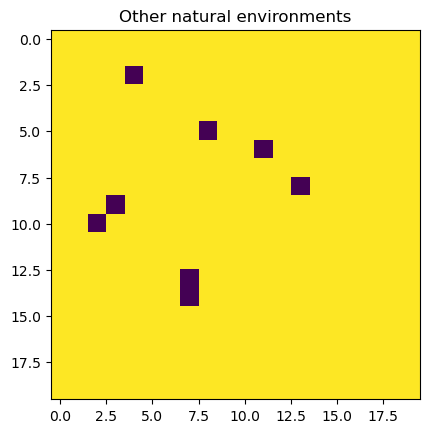

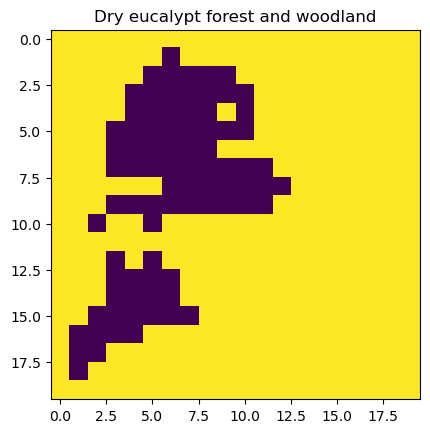

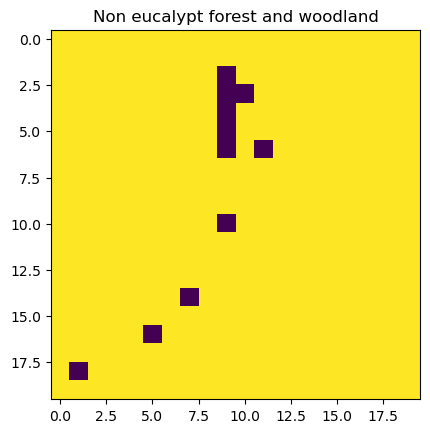

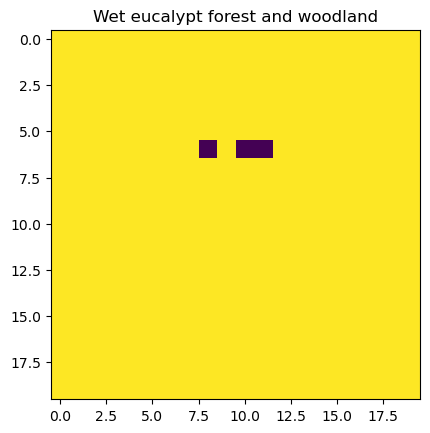

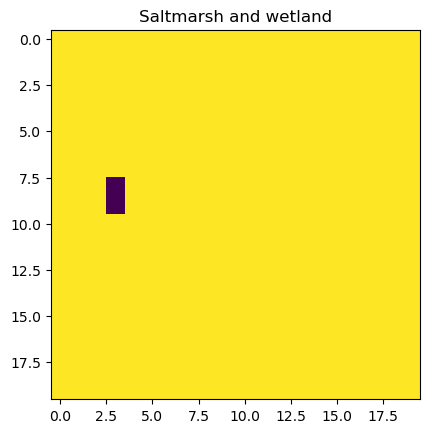

In [15]:
#plot each vegetation type
veg_group={}
for i in subset["VEG_GROUP"].unique():
    subsub=subset[subset["VEG_GROUP"]==i]
    ax=subsub.plot(column="VEG_GROUP")
    ax.set_xlim((lonmin,lonmax))
    ax.set_ylim((latmin,latmax))
    ax.axis('off')    
    plt.savefig(f'./images/{i}.png',bbox_inches='tight',
                    pad_inches=-.05)
    plt.clf()    
    plt.clf()

    #down scale image
    vegtype=cv2.imread(f'./images/{i}.png',0)
    vegtype=cv2.resize(vegtype,dsize=(gridlen,gridlen),
                       interpolation=cv2.INTER_LANCZOS4)
    vegtype[vegtype<255]=0
    veg_group[i]=vegtype
    plt.imshow(veg_group[i])
    plt.title(i)
    plt.show()

### elevation

In [16]:
#read asc file into matrix
grid=np.loadtxt("./LIST_DEM_25M_GLAMORGAN_SPRING_BAY/list_dem_25m_glamorgan_spring_bay.asc", skiprows=6)

#read the header of asc file to map the coordinates
info=pd.read_csv("./LIST_DEM_25M_GLAMORGAN_SPRING_BAY/list_dem_25m_glamorgan_spring_bay.asc",header=None, nrows=6)

#seperate text and int
info['name']=[i.split(' ')[0] for i in info[0]]
info['val']=[float(i.split(' ')[-1] )for i in info[0]]

In [17]:
#convert to int for lower left x,y and cell size
xllcorner=info['val'][info['name']=='xllcorner'].item()
xllcorner=int(xllcorner)
yllcorner=info['val'][info['name']=='yllcorner'].item()
yllcorner=int(round(yllcorner))
cellsize=info['val'][info['name']=='cellsize'].item()
cellsize=int(cellsize)

In [18]:
#get coordinates in matrix form
nrow=range(yllcorner,yllcorner+cellsize*grid.shape[0],cellsize)
ncol=range(xllcorner,xllcorner+cellsize*grid.shape[1],cellsize)

In [19]:
#flip y coordinates
flatarr=[(i,j) for j in nrow for i in ncol]
y=np.flip(np.array([i[1] for i in flatarr]).reshape(grid.shape),axis=0).flatten().tolist()

In [20]:
#create geopandas
export=pd.DataFrame()
export['coords']=list(zip([i[0] for i in flatarr],y))
export['altitude']=grid.flatten()
export['coords'] = export['coords'].apply(shapely.geometry.Point)
output=gpd.GeoDataFrame(export, geometry='coords')

In [21]:
#remove nodata point
output=output[output['altitude']!=-9999]

In [22]:
#convert coordinates
zips = gpd.read_file('./LIST_DEM_25M_GLAMORGAN_SPRING_BAY/municipality_glamorgan_spring_bay.shp')
output=output.set_crs(zips.crs)
output=output.to_crs('epsg:4326')

subset=output.cx[lonmin:lonmax,
              latmin:latmax]

In [23]:
#convert matrix to raster
subset['lon']=subset['coords'].apply(lambda x:x.xy[0][0])
subset['lat']=subset['coords'].apply(lambda x:x.xy[1][0])
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
subset['lat num']=(subset['lat']-latmin)//latunit
subset['lon num']=(subset['lon']-lonmin)//lonunit
subset['id']=list(zip(subset['lat num'].astype(int),subset['lon num'].astype(int)))

C:\Users\tm\Anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\tm\Anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\tm\Anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [24]:
#compute mean altitude by each cell
height=subset.groupby('id').mean()['altitude']

C:\Users\tm\AppData\Local\Temp\ipykernel_12140\3829135953.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  height=subset.groupby('id').mean()['altitude']


In [25]:
#generate raster
altitude=np.zeros(devil.shape)
for i in range(len(height)):
    altitude[height.index[i]]=height.iloc[i]
altitude=np.flip(altitude,axis=0)

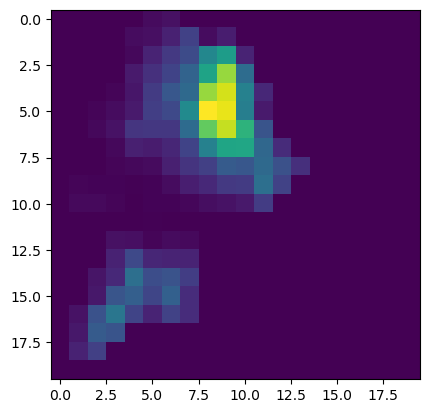

In [26]:
#viz
plt.imshow(altitude)

### matrix form

In [27]:
#generate data
data=pd.DataFrame()
data['devil']=devil.flatten()

#create habitat suitability index
data['index']=data['devil']/data['devil'].max()
arr=altitude.flatten()
data['altitude']=arr

In [28]:
#convert array to binary
arr=baselayer.flatten()
arr[arr==0]=1
arr[arr==255]=0
data['base']=arr

arr=bird.flatten()
arr[arr==0]=1
arr[arr==255]=0
data['seabird']=arr

for i in veg_group:
    arr=veg_group[i].flatten()
    arr[arr==0]=1
    arr[arr==255]=0
    data[i]=arr

### random forest

In [29]:
#remove sea area
land=data[data['base']==1]

#only work on the cells with recorded devil capture
training=land[land['index']!=0]

In [30]:
#train and predict
clf=sklearn.ensemble.RandomForestRegressor()

clf.fit(training[['seabird','altitude',
       'Scrub, heathland and coastal complexes', 'Native grassland',
       'Modified land', 'Other natural environments',
       'Dry eucalypt forest and woodland', 'Non eucalypt forest and woodland',
       'Wet eucalypt forest and woodland', 'Saltmarsh and wetland']],training['index'])

land['pred']=clf.predict(land[['seabird','altitude',
       'Scrub, heathland and coastal complexes', 'Native grassland',
       'Modified land', 'Other natural environments',
       'Dry eucalypt forest and woodland', 'Non eucalypt forest and woodland',
       'Wet eucalypt forest and woodland', 'Saltmarsh and wetland']])

data['pred']=land['pred']

C:\Users\tm\AppData\Local\Temp\ipykernel_12140\2809783232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['pred']=clf.predict(land[['seabird','altitude',


In [31]:
#not bad for scarce data points
clf.score(training[['seabird','altitude',
       'Scrub, heathland and coastal complexes', 'Native grassland',
       'Modified land', 'Other natural environments',
       'Dry eucalypt forest and woodland', 'Non eucalypt forest and woodland',
       'Wet eucalypt forest and woodland', 'Saltmarsh and wetland']],training['index'])

0.8263491780821921

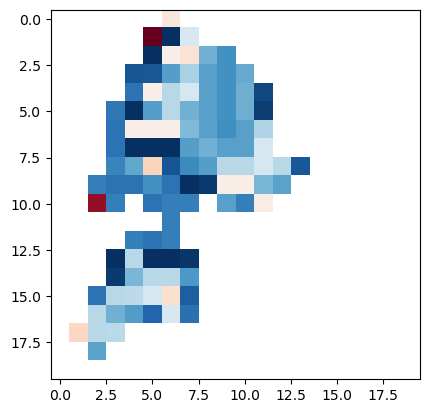

In [32]:
#viz habitat suitability map
plt.imshow(np.array(data['pred']).reshape(gridlen,gridlen),cmap='RdBu_r')